In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from rpy2.robjects.packages import importr

utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages('lme4')

%load_ext rpy2.ipython

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/lme4_1.1-27.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 3311365 bytes (3.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to con

In [3]:
# Load data
utterances = pd.read_csv("results/intelligibility/conversations.csv")

# convert True/False to 0/1:
utterances.replace({False: 0, True: 1}, inplace=True)

utterances.head()


,speaker_code,transcript_raw,tokens,pos,start_time,end_time,age,corpus,transcript_file,child_name,...,is_speech_related,is_intelligible,response_is_speech_related,response_is_intelligible,response_latency,response_latency_follow_up,follow_up_speech_related,follow_up_intelligible,has_response,caregiver_response_contingent
0,CHI,take my nappie .,take my nappie .,v det:poss n .,107826.0,109393.0,24,MPI-EVA-Manchester,/home/mitja/data/CHILDES/MPI-EVA-Manchester/El...,MPI-EVA-Manchester_Eleanor,...,1.0,1,1.0,1,-267.0,19403.0,1.0,1,1,1
1,CHI,don't touch the clock .,don't CLITIC touch the clock .,mod neg v det:art n .,132894.0,135100.0,24,MPI-EVA-Manchester,/home/mitja/data/CHILDES/MPI-EVA-Manchester/El...,MPI-EVA-Manchester_Eleanor,...,1.0,1,1.0,1,198.0,12059.0,1.0,1,1,1
2,CHI,mine .,mine .,pro:poss .,147159.0,149435.0,24,MPI-EVA-Manchester,/home/mitja/data/CHILDES/MPI-EVA-Manchester/El...,MPI-EVA-Manchester_Eleanor,...,1.0,1,1.0,1,-767.0,650.0,1.0,1,1,1
3,CHI,mine .,mine .,pro:poss .,151800.0,152903.0,24,MPI-EVA-Manchester,/home/mitja/data/CHILDES/MPI-EVA-Manchester/El...,MPI-EVA-Manchester_Eleanor,...,1.0,1,1.0,1,-337.0,2264.0,1.0,1,1,1
4,CHI,"no , Mummy .","no , Mummy .",co cm n:prop .,155167.0,157466.0,24,MPI-EVA-Manchester,/home/mitja/data/CHILDES/MPI-EVA-Manchester/El...,MPI-EVA-Manchester_Eleanor,...,1.0,1,1.0,1,22800.0,31841.0,1.0,1,0,0


In [4]:
# Some children have very few data points:
counts = utterances.groupby("child_name").size()
counts

child_name
Braunwald_Laura                 9561
Brent_Alexander                  237
Brent_Allen                        4
Brent_Brooklyn                    10
Brent_Dillon                     988
Brent_Henry                      206
Brent_Jacob_Abernathy              4
Brent_Jaylen                      40
Brent_Maggie                     204
Brent_Miranda                    295
Brent_Morgan                     839
Brent_Tabitha                    381
Brent_Tabitha_Sims                 3
Brent_Timothy                    638
Brent_Tyrese                       6
Brent_Vas                         17
Brent_Vas_Coleman                146
Brent_Xavier                      15
MPI-EVA-Manchester_Eleanor     53266
MPI-EVA-Manchester_Fraser     108201
Peters_Seth                     9394
Sachs_Naomi                     5984
Soderstrom_Joseph                859
Soderstrom_Theo                  780
dtype: int64

In [5]:
# Exclude children with less than 100 datapoints:
# child_names_enough_data = [name for name, count in counts.items() if count > 100]
# print(len(utterances))
# utterances = utterances[utterances.child_name.isin(child_names_enough_data)]
# print(len(utterances))

## Caregiver Contingency
### By child

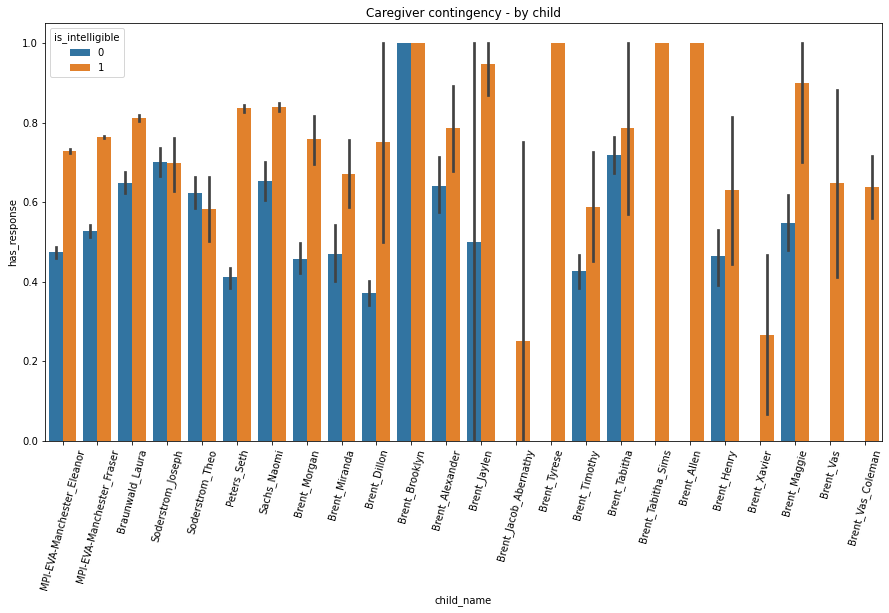

In [6]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.figure()
sns.barplot(
        data=utterances,
        x="child_name",
        y="has_response",
        hue="is_intelligible"
)
plt.title("Caregiver contingency - by child")
plt.xticks(rotation=75)
plt.subplots_adjust(bottom=0.3)

### By Age

Text(0.5, 1.0, 'Caregiver contingency - by age')

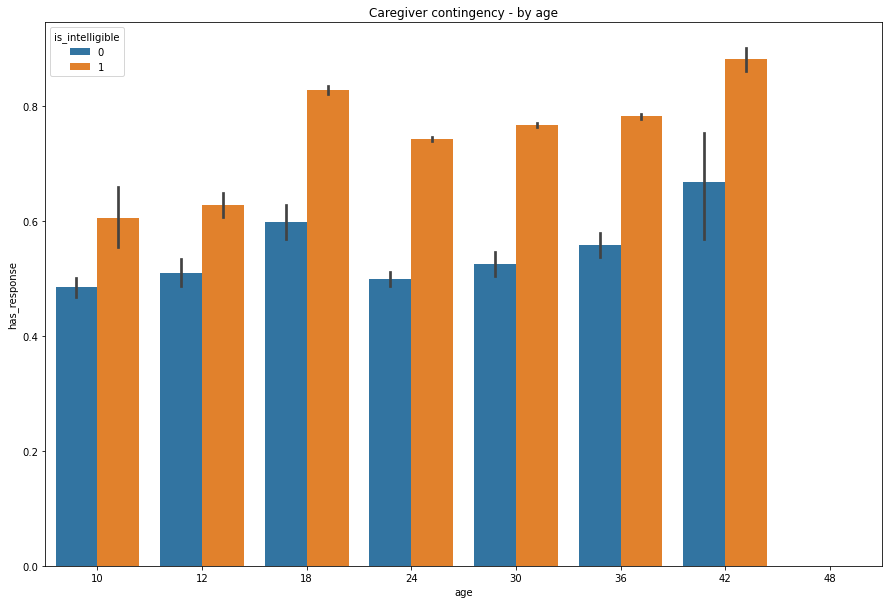

In [7]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.barplot(
        data=utterances,
        x="age",
        y="has_response",
        hue="is_intelligible"
)
plt.title("Caregiver contingency - by age")

## Child contingency
### By Child


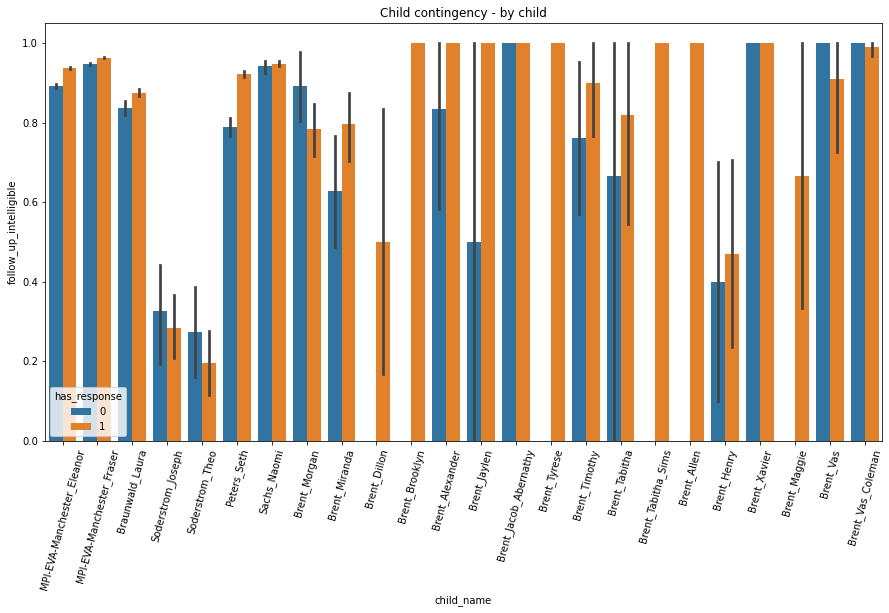

In [8]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.figure()
sns.barplot(
        data=utterances[utterances["is_intelligible"] == 1],
        x="child_name",
        y="follow_up_intelligible",
        hue="has_response"
)
plt.title("Child contingency - by child")
plt.xticks(rotation=75)
plt.subplots_adjust(bottom=0.3)

### By Age

Text(0.5, 1.0, 'Child contingency - by age')

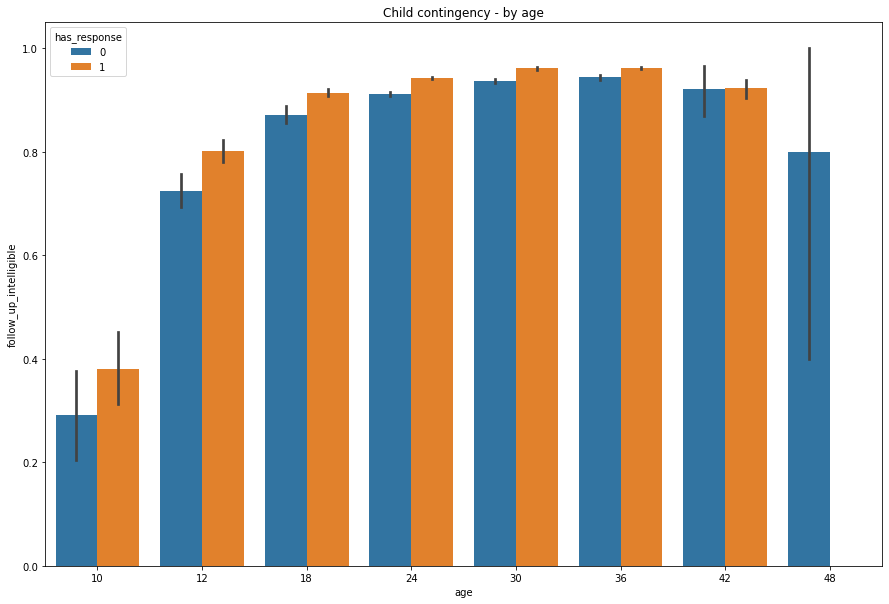

In [9]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.barplot(
        data=utterances[utterances["is_intelligible"] == 1],
        x="age",
        y="follow_up_intelligible",
        hue="has_response"
)
plt.title("Child contingency - by age")

## Caregiver contingency
### GLM (with mixed effects)

In [10]:
# normalize age
min_age, max_age = utterances["age"].min(), utterances["age"].max()
utterances["age"] = (utterances["age"] - min_age) / (max_age - min_age) * (1 - 0)


In [11]:
%%R -i utterances
library(lme4)

# Caregiver contingency
m_caregiver_contingency<-glmer('has_response ~ is_intelligible * age + (1 | child_name)', data=utterances, family=binomial) #, control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
print(summary(m_caregiver_contingency))


R[write to console]: Loading required package: Matrix



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: has_response ~ is_intelligible * age + (1 | child_name)
   Data: utterances

      AIC       BIC    logLik  deviance  df.resid 
 214022.8  214073.7 -107006.4  214012.8    192073 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9731 -0.8832  0.5448  0.5901  1.2958 

Random effects:
 Groups     Name        Variance Std.Dev.
 child_name (Intercept) 0.3622   0.6018  
Number of obs: 192078, groups:  child_name, 24

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.06781    0.11128  -0.609    0.542    
is_intelligible      1.24133    0.03168  39.178  < 2e-16 ***
age                  1.38466    0.06294  22.001  < 2e-16 ***
is_intelligible:age -0.37295    0.06396  -5.831 5.52e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) i

## Child Contingency
### GLM (with mixed effects)

In [12]:
%%R -i utterances
library(lme4)

utterances_child_intelligible = subset(utterances, is_intelligible==1)

# Child contingency
m_child_contingency<-glmer('follow_up_intelligible ~ has_response * age + (1 | child_name)', data=utterances_child_intelligible, family=binomial)
print(summary(m_child_contingency))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: follow_up_intelligible ~ has_response * age + (1 | child_name)
   Data: utterances_child_intelligible

     AIC      BIC   logLik deviance df.resid 
 74707.4  74757.7 -37348.7  74697.4   175025 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.6869  0.1860  0.2082  0.2681  2.2751 

Random effects:
 Groups     Name        Variance Std.Dev.
 child_name (Intercept) 2.431    1.559   
Number of obs: 175030, groups:  child_name, 24

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       1.36116    0.20125   6.764 1.35e-11 ***
has_response      0.69803    0.05212  13.392  < 2e-16 ***
age               1.95006    0.09699  20.105  < 2e-16 ***
has_response:age -0.52108    0.11031  -4.724 2.32e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) 